# Feature Engineering For Merchants

* Features:
    * The Average Price and Score For the past 30 days
    * The difference between the average price and the average price of merchants in the same category, the category includes kind and location.
    * The average exposure rate for the past 30 days and 7 days

In [1]:
import pandas as pd
import os
print(os.getcwd())

/workdir/data/uec_tangc22


In [2]:
train = pd.read_csv('/workdir/data/uec_1149625019/merged_data/train_request_uuid_poi_prices.csv')

In [6]:
train['门店标题'].apply(lambda x:len(x)).max()

50

In [8]:
with open('stopwords.txt','r',encoding = 'utf-8') as f:
    stopwords_list = [line.strip() for line in f.readlines()]
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import jieba
import numpy as np
def clean_word(x):
    if x is not np.nan:
        words = jieba.lcut(x.strip())
        words = [word.strip('.,!?/"-.()&').lower() for word in words if word not in stopwords_list]  
        return ' '.join(words)

In [9]:
vocab_size = 10000
X = train['门店标题'].apply(clean_word)
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X.tolist())
X = tokenizer.texts_to_sequences(X.tolist())

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.491 seconds.
Prefix dict has been built successfully.


In [1]:
import pandas as pd
train = pd.read_csv('/workdir/data/作业3：广告方向/910f1a6b-广告CTR预估/910f1a6b-table_impr_click_action_train.csv')
poi = pd.read_csv('/workdir/data/作业3：广告方向/910f1a6b-广告CTR预估/910f1a6b-table_poi_detail.csv')
deal = pd.read_csv('/workdir/data/作业3：广告方向/910f1a6b-广告CTR预估/910f1a6b-table_deal_detail.csv')
test = pd.read_csv('/workdir/data/作业3：广告方向/910f1a6b-广告CTR预估/910f1a6b-table_impr_click_action_test_nolabel.csv')


In [2]:
print(train.columns)
print(poi.columns)
print(deal.columns)
print(test.columns)

Index(['Unnamed: 0', 'label', '请求ID', '门店ID', '位次', '日期'], dtype='object')
Index(['门店ID', '门店标题', '门店一级类目', '门店二级类目', '门店三级类目', '门店商圈', '门店纬度', '门店经度',
       '平均分数', '平均价格'],
      dtype='object')
Index(['门店ID', '团单价格', '团单原始价格', '团单ID'], dtype='object')
Index(['Unnamed: 0', 'ID', '请求ID', '门店ID', '日期'], dtype='object')


In [12]:
poi['平均分数'].isnull().astype('int').sum()

6158

In [10]:
test['门店ID'].nunique()

141685

In [4]:
shop_id = pd.DataFrame()
shop_id[['门店ID','门店一级类目', '门店二级类目', '门店三级类目', '门店商圈','平均分数']] = poi[['门店ID','门店一级类目', '门店二级类目', '门店三级类目', '门店商圈','平均分数']]
# Average Price
shop_id =shop_id.merge(deal.groupby('门店ID')[['团单价格','团单原始价格']].mean(),how='left',on = '门店ID')

In [5]:
# 一级类目平均价格价差 Average Price Spread for Category 1
shop_id['fir_category_price_diff'] = shop_id['团单价格'] - shop_id.groupby('门店一级类目')['团单价格'].transform('mean')
# 二级类目平均价格价差 Average Price Spread for Category 2
shop_id['sec_category_price_diff'] = shop_id['团单价格'] - shop_id.groupby('门店二级类目')['团单价格'].transform('mean')
# 三级类目平均价格价差 Average Price Spread for Category 3
shop_id['thi_category_price_diff'] = shop_id['团单价格'] - shop_id.groupby('门店三级类目')['团单价格'].transform('mean')
# 一级类目平均分数分差 Average Score Spread for Category 1
shop_id['fir_category_score_diff'] = shop_id['平均分数'] - shop_id.groupby('门店一级类目')['平均分数'].transform('mean')
# 二级类目平均分数分差 Average Score Spread for Category 2
shop_id['sec_category_score_diff'] = shop_id['平均分数'] - shop_id.groupby('门店二级类目')['平均分数'].transform('mean')
# 三级类目平均分数分差 Average Score Spread for Category 3
shop_id['thi_category_score_diff'] = shop_id['平均分数'] - shop_id.groupby('门店三级类目')['平均分数'].transform('mean')
# 商圈平均价格价差
shop_id['mall_price_diff'] = shop_id['团单价格'] - shop_id.groupby('门店商圈')['团单价格'].transform('mean')
# 商圈平均分数分差
shop_id['mall_score_diff'] = shop_id['平均分数'] - shop_id.groupby('门店商圈')['平均分数'].transform('mean')

In [6]:
# Average Exposure Rate/ Recent Exposure Rate
shop_id = shop_id.merge(train.groupby('门店ID')['请求ID'].count().rename('all_expose'),how='left',on = '门店ID')
shop_id = shop_id.merge(train[train['label']==1].groupby('门店ID')['请求ID'].count().fillna(0).rename('all_click'),how='left',on = '门店ID')
shop_id = shop_id.merge(train.groupby('门店ID')['位次'].mean().rename('average_position'),how='left',on = '门店ID')
min_date = '2022-08-23'
shop_id = shop_id.merge(train[train['日期']>=min_date].groupby('门店ID')['请求ID'].count().fillna(0).rename('recent_expose'),how='left',on = '门店ID')
shop_id = shop_id.merge(train[(train['日期']>=min_date)&(train['label']==1)].groupby('门店ID')['请求ID'].count().fillna(0).rename('recent_click'),how='left',on = '门店ID')



In [7]:
shop_id[['门店纬度', '门店经度']] = poi[['门店纬度', '门店经度']]

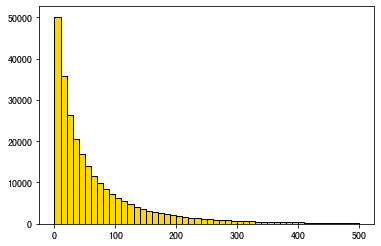

In [32]:
import matplotlib.pyplot as plt
plt.hist(shop_id['all_expose'],range=(0,500),bins=50,color='gold',edgecolor='black')
plt.show()

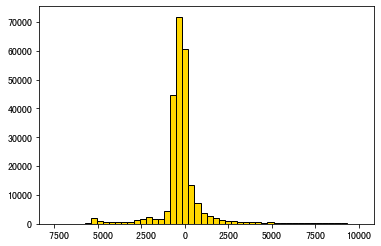

In [34]:
plt.hist(shop_id['fir_category_price_diff'],range=(-7500,10000),bins=50,color='gold',edgecolor='black')
plt.show()

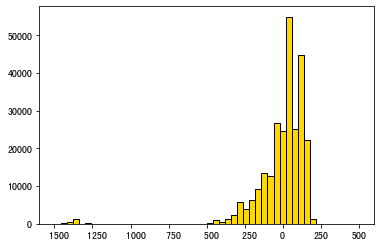

In [35]:
plt.hist(shop_id['fir_category_score_diff'],range=(-1500,500),bins=50,color='gold',edgecolor='black')
plt.show()

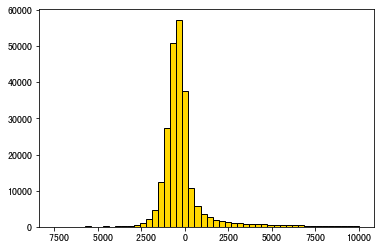

In [36]:
plt.hist(shop_id['mall_price_diff'],range=(-7500,10000),bins=50,color='gold',edgecolor='black')
plt.show()

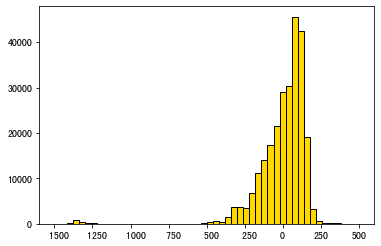

In [37]:
plt.hist(shop_id['mall_score_diff'],range=(-1500,500),bins=50,color='gold',edgecolor='black')
plt.show()

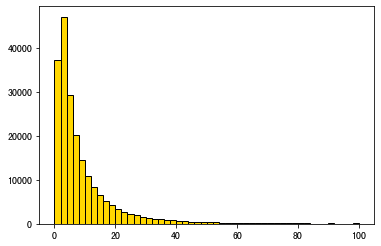

In [33]:
plt.hist(shop_id['all_click'],range=(0,100),bins=50,color='gold',edgecolor='black')
plt.show()

In [31]:
shop_id.to_csv('poi_manual.csv')

In [32]:
shop_id.columns

Index(['门店ID', '门店一级类目', '门店二级类目', '门店三级类目', '门店商圈', '平均分数', '团单价格', '团单原始价格',
       'fir_category_price_diff', 'sec_category_price_diff',
       'thi_category_price_diff', 'fir_category_score_diff',
       'sec_category_score_diff', 'thi_category_score_diff', 'mall_price_diff',
       'mall_score_diff', 'all_expose', 'all_click', 'average_position',
       'recent_expose', 'recent_click', '门店纬度', '门店经度'],
      dtype='object')